In [1]:
#!/usr/bin/env python

'''
DESCRIPTION
-----------
    LocalOutlierFactor with trained model

RETURN
------
    {DATASET}_lof_seen.png : png file
        Similarity scores of seen label
    {DATASET}_lof_seen.png : png file
        Similarity score of unseen label

EXPORTED FILE(s) LOCATION
-------------------------
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_seen.png
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_unseen.png
'''

# importing default libraries
import os, argparse, sys
# sys.path.append('./')
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import config as src

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
# from sklearn.neighbors import LocalOutlierFactor
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import glob
TINY_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=12)    # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## MELANOMA

In [3]:
loc_output = './reports/retrieval_lof/exper_melanoma'

df_query = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
df_reference = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')

X_query = df_query.iloc[:, :-1].values
y_ground_truth_query = df_query.iloc[:, -1:]

X_reference = df_reference.iloc[:, :-1].values
y_ground_truth_reference = df_reference.iloc[:, -1:]


In [4]:
order_plot = list(np.unique(y_ground_truth_reference))
seen_label = dict(zip(order_plot, range(len(order_plot))))
order_plot.append('Neg.cell')
unseen_label = dict(zip(order_plot, range(len(order_plot))))
print(seen_label)
print(unseen_label)

{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4}
{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4, 'Neg.cell': 5}


## FULL MODEL

In [5]:
model_name = '1_layer_signaling'
model , model_encoding = src.loading_model(f'./models/exper_melanoma/train_test_split/design_{model_name}_reference_log1p_Adam_relu_0.h5', -1)
model_encoding.summary()

Loaded model!! ./models/exper_melanoma/train_test_split/design_1_layer_signaling_reference_log1p_Adam_relu_0.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 17994)]           0         
_________________________________________________________________
layer1 (Dense)               (None, 93)                1673535   
Total params: 1,673,535
Trainable params: 1,673,535
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoding_query = model_encoding.predict(X_query)
encoding_reference = model_encoding.predict(X_reference)

print(encoding_query.shape)
print(encoding_reference.shape)

(3412, 93)
(2761, 93)


In [7]:
threshold, df_lof_reference, df_lof_query = src.calculate_threshold(encoding_with_seen=encoding_reference
                                                                , encoding_with_unseen=encoding_query
                                                                , y_with_seen=y_ground_truth_reference
                                                                , y_with_unseen=y_ground_truth_query)

Threshold value from reference dataset,  -1.2726364248557516


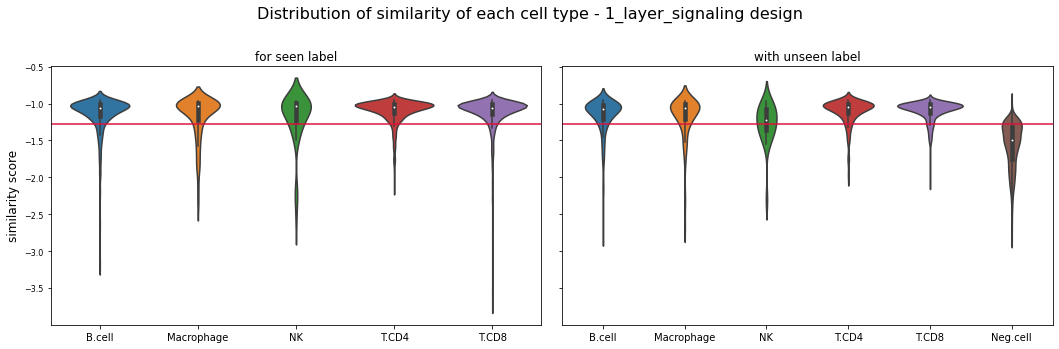

In [8]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_lof_reference, ax=axes[0], order=seen_label)
sns.violinplot(x="cell_type", y="score", data=df_lof_query, ax=axes[1], order=unseen_label)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of each cell type - '+model_name+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_'+model_name+'.png'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_'+model_name+'.pdf'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_'+model_name+'.svg'), dpi=300, bbox_inches = 'tight')

In [9]:
df_lof_query['threshold'] = 'above'
df_lof_query.loc[df_lof_query['score']<=threshold, 'threshold'] = 'below'
# (df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100
df_lof_query[df_lof_query['cell_type']=='Neg.cell'].groupby('threshold').size()  / len(df_lof_query[df_lof_query['cell_type']=='Neg.cell'])

threshold
above    0.15754
below    0.84246
dtype: float64

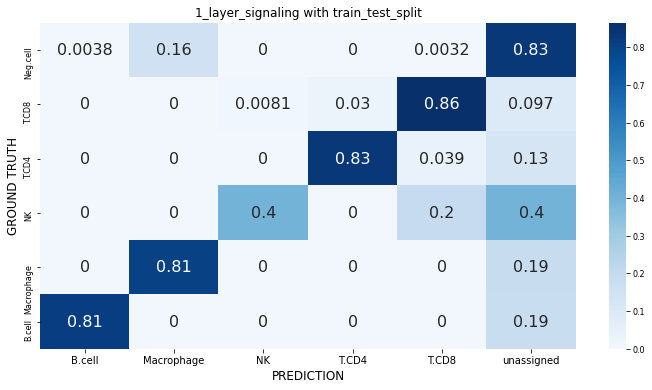

In [10]:
## scibet comparison

df_pred_truth = src.scibet_compare(y_with_seen=y_ground_truth_reference
                                   , y_with_unseen=y_ground_truth_query
                                   , X_with_unseen=X_query
                                   , lof_unseen=df_lof_query
                                   , model=model
                                   , threshold=threshold)

df_logo_crosstab = pd.crosstab(df_pred_truth['cell_type'], df_pred_truth['pred'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)
df_logo_crosstab

src.scibet_confusion_matrix(df_logo_crosstab)
plt.title(f'{model_name} with train_test_split')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_'+model_name+'.png'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_'+model_name+'.pdf'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_'+model_name+'.svg'), dpi=300, bbox_inches = 'tight')

## LOGO

In [11]:
LOGO_encoding_q = pd.DataFrame()
LOGO_encoding_r = pd.DataFrame()
model_name = '1_layer_signaling'

for i_ in range(5):
    _, model_encoding = src.loading_model(f'./models/exper_melanoma/LeaveOneGroupOut/design_{model_name}_reference_log1p_Adam_relu_'+str(i_)+'.h5', -1)
    encoding_prediction_q = model_encoding.predict(X_query)
    encoding_prediction_r = model_encoding.predict(X_reference)
    LOGO_encoding_q = pd.concat([LOGO_encoding_q, pd.DataFrame(encoding_prediction_q)], axis=1)
    LOGO_encoding_r = pd.concat([LOGO_encoding_r, pd.DataFrame(encoding_prediction_r)], axis=1)

Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_Adam_relu_0.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_Adam_relu_1.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_Adam_relu_2.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_Adam_relu_3.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_Adam_relu_4.h5


In [12]:
threshold, df_lof_reference, df_lof_query = src.calculate_threshold(encoding_with_seen=LOGO_encoding_r
                                                                , encoding_with_unseen=LOGO_encoding_q
                                                                , y_with_seen=y_ground_truth_reference
                                                                , y_with_unseen=y_ground_truth_query)

Threshold value from reference dataset,  -1.2815824141005094


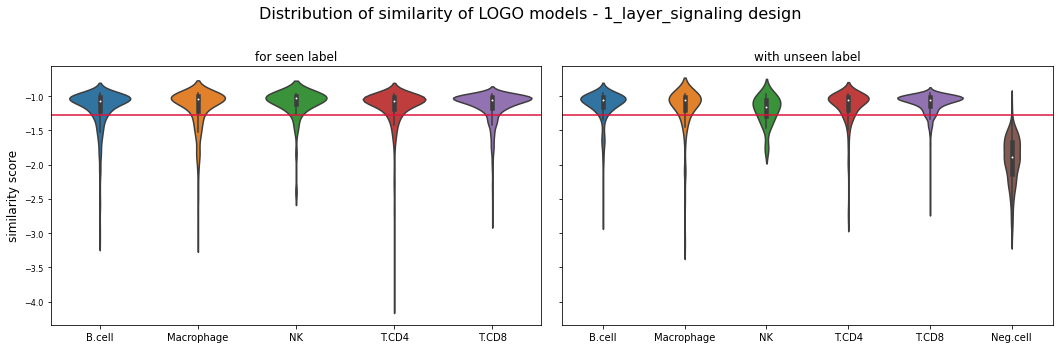

In [13]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_lof_reference, ax=axes[0], order=seen_label)
sns.violinplot(x="cell_type", y="score", data=df_lof_query, ax=axes[1], order=unseen_label)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of LOGO models - '+model_name+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_LOGO_'+model_name+'.png'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_LOGO_'+model_name+'.pdf'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_LOGO_'+model_name+'.svg'), dpi=300, bbox_inches = 'tight')

In [14]:
df_lof_query['threshold'] = 'above'
df_lof_query.loc[df_lof_query['score']<=threshold, 'threshold'] = 'below'
# (df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100
df_lof_query[df_lof_query['cell_type']=='Neg.cell'].groupby('threshold').size()  / len(df_lof_query[df_lof_query['cell_type']=='Neg.cell'])

threshold
above    0.006284
below    0.993716
dtype: float64

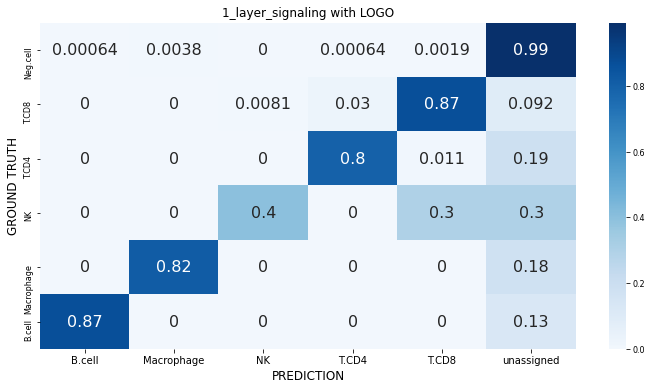

In [15]:
## scibet comparison

df_pred_truth = src.scibet_compare(y_with_seen=y_ground_truth_reference
                                   , y_with_unseen=y_ground_truth_query
                                   , X_with_unseen=X_query
                                   , lof_unseen=df_lof_query
                                   , model=model
                                   , threshold=threshold)

df_logo_crosstab = pd.crosstab(df_pred_truth['cell_type'], df_pred_truth['pred'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)
df_logo_crosstab

src.scibet_confusion_matrix(df_logo_crosstab)
plt.title(f'{model_name} with LOGO')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_LOGO_'+model_name+'.png'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_LOGO_'+model_name+'.pdf'), dpi=300, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, 'confusion_matrix_scibet_LOGO_'+model_name+'.svg'), dpi=300, bbox_inches = 'tight')